# Universal Pleasantness

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrfume
import pystan
import seaborn as sns
from wurlitzer import sys_pipes
sns.set(font_scale=1.2)

### Load the data (excludes New York or the DREAM model for now)

In [2]:
df = pyrfume.load_data('mainland_unpub/UniversalPleasantness/All data pleasantness_CORRECTED_2.txt', sep='\t')
df.head()

,"Sex (1= women, 2= man)",Age in years,Language/Group,1) Odor plesantness (most pleasant),2) Odor plesantness,3) Odor plesantness,4) Odor plesantness,5) Odor plesantness,6) Odor plesantness,7) Odor plesantness,8) Odor plesantness,9) Odor plesantness,10) Odor plesantness (most unpleasant)
Participant number,,,,,,,,,,,,,
1,1,32,Mexican Spanish,5,2,4,3,7,6,1,9,8,10
2,1,20,Mexican Spanish,4,5,1,2,8,7,6,10,3,9
3,1,41,Mexican Spanish,4,1,2,3,5,6,9,8,7,10
4,1,22,Mexican Spanish,4,2,3,5,6,1,9,7,8,10
5,1,29,Mexican Spanish,4,1,3,6,2,5,9,7,8,10


In [243]:
# Get the unique groups
groups = list(df['Language/Group'].unique())
groups

['Mexican Spanish',
 'Seri',
 'Imbabura Quichua',
 'Chapalaa',
 'Thai',
 'Semaq Beri',
 'Semelai',
 'MahMeri',
 'Maniq']

### The model in Stan (a probabilistic programming language for fitting Bayesian models)

In [52]:
stan_code = """

functions {
    // This implements a Plackett-Luce ranking model
    // See https://cran.rstudio.com/web/packages/PlackettLuce/vignettes/Overview.html
    // or https://icml.cc/Conferences/2009/papers/347.pdf
    real log_p_ranks(real[] w, int[] ranks, int n) {
        real log_p = 0; // Initializing log-probability
        real sum_exp_w = sum(exp(w)); // The denominator for normalization
        for (i in 1:n) {
            // For each rank (descending), the probability is the e^valence
            // normalized to all the sum of the remaining e^valence
            real e_w_i = exp(w[ranks[i]]); # Convert the latent value into a non-negative score
            log_p += log(e_w_i / sum_exp_w); // Increment log-probability according to the model
            sum_exp_w -= e_w_i; // Remove the just-ranked item from the denominator
            }
        return log_p;
        }
    }
    
data {
    int<lower=1> n_odorants; // e.g. 10
    int<lower=1> n_individuals; // e.g. ~200
    int<lower=1, upper=n_individuals> n_groups; // e.g. ~9
    int<lower=1, upper=n_groups> group_id[n_individuals]; // The integer group IDs of each indivudal
    int<lower=1, upper=n_odorants> ranks[n_individuals, n_odorants]; // The matrix of ranks
    }
    
// These are the values for the model to estimate
parameters {
    real mu_global[n_odorants]; // The global valence for each odorant
    real mu_group[n_groups, n_odorants]; // The group-level valences for each odorant
    real mu[n_individuals, n_odorants]; // The individual-level valences for each odorant
    real<lower=0.0001> sigma_global; // The variability of the distribution from which global valences are drawn
    real<lower=0.0001> sigma_group; // The variability of the conditional distribution from which group valences are drawn
    real<lower=0.0001> sigma; // The variability of the conditional distribution from which individual valences are drawn
    }
    
// The model also indirectly estimates this, but it is only used to center the valences
transformed parameters {
    real mu_mean = mean(mu_global); // The mean global valence (across odorants)
}
    
model {
    mu_mean ~ normal(0, 0.001); // Enforce that the mean (latent) global valence is 0.  Required for identifiability.
    mu_global ~ normal(0, sigma_global); // Global odorant valences have a very weak prior
    sigma_global ~ lognormal(0, 1); // Group level variance has a very weak prior
    sigma_group ~ lognormal(0, 1); // Group level variance has a very weak prior
    sigma ~ lognormal(0, 1); // Individual level variance has a very weak prior
    for (i in 1:n_groups) {
        mu_group[i] ~ normal(mu_global, sigma_group); // Group odorant valences will be distributed around the global values.
        }
    for (i in 1:n_individuals) {
        mu[i] ~ normal(mu_group[group_id[i]], sigma); // Individual odorant valences will be distributed around the group values.
        target += log_p_ranks(mu[i], ranks[i], n_odorants); // The data likelihood (using Pluckett-Luce model)
        }
    }
"""

In [53]:
# Compile the model
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2edc26e568cde1ef4667b95144e97ce NOW.


### Fit the model

In [61]:
# The data that needs to be passed to the Stan model
data = {
    'n_odorants': 10, # How many odorants
    'n_individuals': df.shape[0], # How many individuals
    'n_groups': len(groups), # How many groups
    'group_id': df['Language/Group'].apply(lambda x: groups.index(x)+1).values, # Integer group IDs for each individual
    'ranks': df.iloc[:, -10:].values  # The last 10 columns of the dataframe, i.e. the ranking data
}

with sys_pipes(): # Used to pipe C-level output to the browser so I can see sampling messages.
    # Sample (fit) the model
    # None of these parameters matter except in the sense that sampling must proceed
    # slowly enough to get the answer without getting infinities.
    # This is all standard fare.  
    %time fit = model.sampling(data=data, warmup=5000, iter=20000, chains=4, control={'adapt_delta': 0.9, 'max_treedepth': 12})
    # You may see many warning messages but basically as long as nothing blows up and Rhat ~ 1 then it is OK.

# Put the results into a Pandas dataframe
samples = fit.to_dataframe()


Gradient evaluation took 0.000694 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.94 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.0007 seconds
1000 transitions using 10 leapfrog steps per transition would take 7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000668 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000877 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.77 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Itera

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 15.1 s, sys: 9.82 s, total: 24.9 s
Wall time: 1h 26min 45s


### Some summary statistics of the fit

In [173]:
#fit

In [178]:
# Checking the log-posterior mean and std for the various chains (independent sampling runs)
#for chain in range(4):
#    s = samples[samples['chain']==chain]['lp__']
#    print("Chain %d:, Log-posterior = %.4g +/- %.3g" % (chain, s.mean(), s.std()))

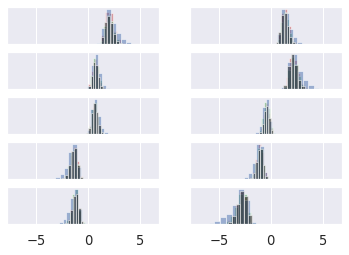

In [183]:
# Check to see if chains (independent sampling runs) agree
# This will be indiciated by each panel having 4 very similary (heavily overlapping) histograms
fig, axes = plt.subplots(5, 2, sharex=True)
for i, ax in enumerate(axes.flat):
    odorant_id = i + 1
    for chain in range(4):
        chain_samples = samples[samples['chain']==chain]
        global_odor_valence = chain_samples['mu_global[%d]' % odorant_id]
        # Plot the histogram of global valence samples for each odorant
        ax.hist(global_odor_valence, color='rgbk'[chain], alpha=0.5)
        ax.axes.get_yaxis().set_visible(False)

### Show how the group mean valences for each odorant compare.  Order by global mean valence.

In [184]:
# Compute global mean valences for each odorant
global_means = [samples['mu_global[%d]' % (j+1)].mean() for j in range(data['n_odorants'])]
# Get their order (by global mean descending) so we can plot all data in a common, sensible order
order = np.argsort(global_means)[::-1]

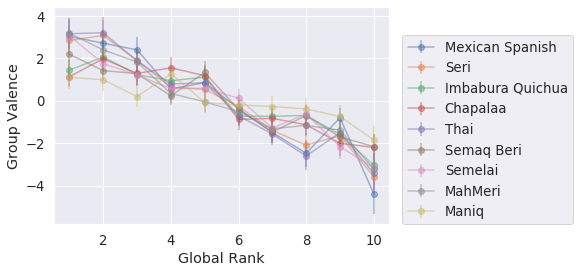

In [185]:
for i, group in enumerate(groups):
    m = [samples['mu_group[%d,%d]' % (i+1, j+1)].mean() for j in order]
    s = [samples['mu_group[%d,%d]' % (i+1, j+1)].std() for j in order]
    plt.errorbar(range(1, n+1), m, yerr=s, alpha=0.5, marker='o', label=group)
plt.xlabel('Global Rank')
plt.ylabel('Group Valence')
plt.legend(loc=(1.04, 0));

### What is the contribution of global variability (across odorants)?
### Of group variability?
### Of individual variability?

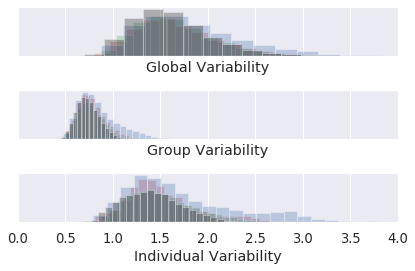

In [93]:
sigmas = {'Global Variability': 'sigma_global',
          'Group Variability': 'sigma_group',
          'Individual Variability': 'sigma'}
fig, ax = plt.subplots(len(sigmas), 1, sharex=True)
for j in range(4): # Over chains
    s = samples[samples['chain']==j]
    for i, (name, var) in enumerate(sigmas.items()):
        ax[i].hist(s[var], bins=25, color='rgbk'[j], alpha=0.3)
        ax[i].axes.get_yaxis().set_visible(False)
        ax[i].set_xlabel(name)
        ax[i].set_xlim(0, 4)
plt.tight_layout()

In [187]:
# Continue sampling from the last sample of the previous fit
#means = [fit.unconstrain_pars({key: value.mean(axis=0) for key, value in fit.extract().items()})]*4
#means = [{key: value.mean(axis=0) for key, value in fit.extract().items()}]*4
#with sys_pipes():
#    %time fit2 = model.sampling(data=data, warmup=1000, iter=10000, chains=4, control={'adapt_delta': 0.9, 'max_treedepth': 12}, init=means);

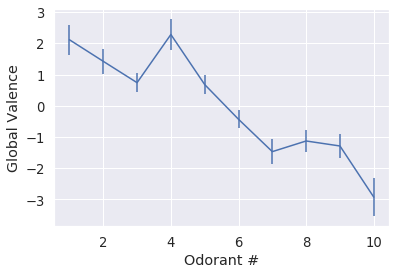

In [188]:
# How do the odors differ in global valence?
# Note that 0 is meaningless (it is not the transition between pleasant and unpleasant)
# Results would be identical of a constant was added to all values
m = [samples['mu_global[%d]' % odorant].mean() for odorant in range(1, data['n_odorants']+1)]
s = [samples['mu_global[%d]' % odorant].std() for odorant in range(1, data['n_odorants']+1)]
plt.errorbar(range(1, data['n_odorants']+1), m, yerr=s)
plt.xlabel('Odorant #')
plt.ylabel('Global Valence');

### Latent Valences (each group against each other group)

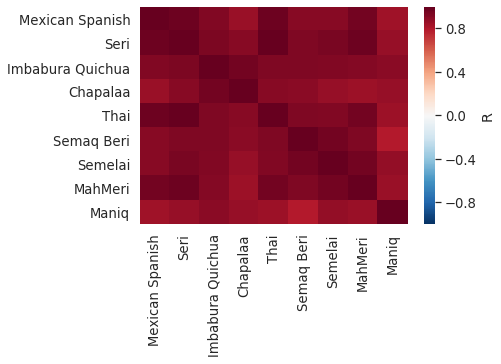

In [273]:
mu_group = pd.DataFrame([[samples['mu_group[%d,%d]' % (group+1, odorant+1)].mean()
                      for group in range(len(groups))]
                     for odorant in range(data['n_odorants'])],
                        index=range(1, data['n_odorants']+1), columns=groups)
sns.heatmap(mu_group.corr(), vmin=-1, vmax=1, cmap='RdBu_r', cbar_kws={'label': 'R'});

In [275]:
mu_group

,Mexican Spanish,Seri,Imbabura Quichua,Chapalaa,Thai,Semaq Beri,Semelai,MahMeri,Maniq
1,2.706860,3.072539,2.060051,1.977225,3.200511,1.416661,1.742367,2.395046,0.985452
2,2.392257,1.898274,1.225472,1.282954,1.875489,1.274896,1.214609,1.820926,0.193348
3,0.554901,0.636312,0.939529,1.547868,0.783968,0.222150,0.568371,0.335223,1.264385
4,3.030039,2.836773,1.437977,1.129648,3.150950,2.183959,3.063848,3.165821,1.100884
5,0.850184,0.532979,1.109171,1.177633,0.845734,1.327767,0.587916,-0.056153,-0.084869
6,-0.369228,-0.262515,-0.726423,-0.886263,-0.708479,-0.419810,0.113173,-0.518225,-0.206267
7,-0.804754,-1.652221,-1.594632,-2.005734,-1.514299,-1.709436,-2.171017,-1.390245,-0.746547
8,-1.498971,-1.395740,-0.739950,-0.832006,-1.573830,-1.479015,-1.294854,-1.326436,-0.276553
9,-2.480720,-2.097115,-0.694480,-1.140510,-2.603919,-0.703714,-0.630801,-1.163260,-0.391725
10,-4.391004,-3.579043,-3.046513,-2.207597,-3.429630,-2.166991,-3.161712,-3.225737,-1.847413


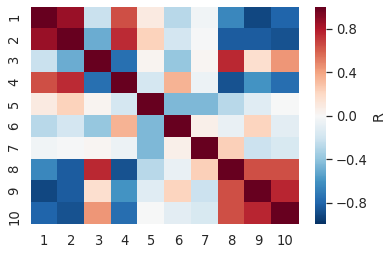

In [274]:
sns.heatmap(mu_group.T.corr(), vmin=-1, vmax=1, cmap='RdBu_r', cbar_kws={'label': 'R'});

### Latent Valences (each group against the mean of the remaining groups)

In [190]:
rs = pd.Series([mu_group[group].corr(mu_group.drop(group, axis=1).mean(axis=1)) for group in groups], index=groups)
rs

Mexican Spanish     0.964534
Seri                0.988821
Imbabura Quichua    0.963041
Chapalaa            0.919716
Thai                0.979766
Semaq Beri          0.949645
Semelai             0.957151
MahMeri             0.972018
Maniq               0.886461
dtype: float64

### Now that we are in the latent space it makes sense to do PCA again (we have continuous, unconstrained values)

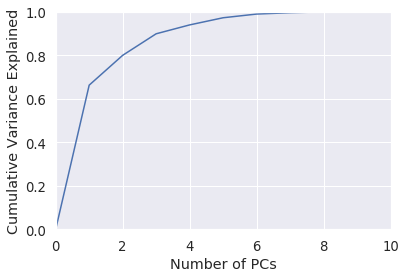

In [220]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(mu_group.T)
explained = [0] + list(pca.explained_variance_ratio_.cumsum())
plt.plot(range(mu_group.shape[1]+1), explained, '-')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Variance Explained");

### And now it is also possible to show individuals clustering around their group means using this approach, because we've factored out all of the other sources of variance

In [230]:
mu = pd.DataFrame([[samples['mu[%d,%d]' % (individual+1, odorant+1)].mean()
                      for individual in range(data['n_individuals'])]
                     for odorant in range(data['n_odorants'])],
                        index=range(1, data['n_odorants']+1), columns=range(data['n_individuals']))

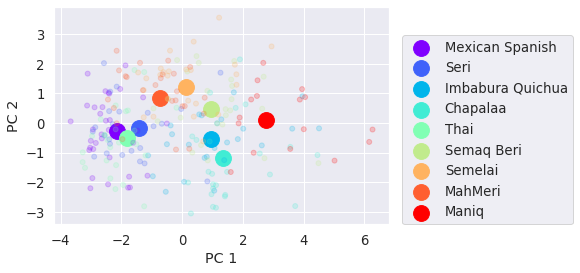

In [269]:
pca = PCA(n_components=2)
pca.fit(mu_group.T)
assert list(mu_group.columns) == list(groups)
group_colors = plt.cm.rainbow(np.linspace(0, 1, len(groups)))
group_ids = df['Language/Group'].apply(lambda x: groups.index(x)+1).values
individual_colors = [group_colors[group_ids[i]-1] for i in range(len(group_ids))]
#plt.scatter(*pca.transform(mu_group.T).T, c=group_colors, s=250, label='Dummy');

# Plot all the groups as big dots
for i, group in enumerate(groups):
    plt.scatter(*pca.transform(mu_group[[group]].T).T, c=group_colors[i].reshape(1, -1), s=250, label=group);
    
# Plot all the individuals as small dots
plt.scatter(*pca.transform(mu.T).T, c=individual_colors, s=25, alpha=0.2);
plt.xlabel('PC 1')
plt.ylabel('PC 2');
plt.legend(loc=(1.04, 0));